In [1]:
# Predict the SalePrice
__author__ = 'mizio'
# import csv as csv
import numpy as np
import pandas as pd
# import matplotlib
# matplotlib.use('TkAgg')
import pylab as plt
from fancyimpute import MICE
# import sys
# sys.path.append('/custom/path/to/modules')
import random
# from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages
import datetime
# import math

Using TensorFlow backend.
/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class HousePrices(object):
    def __init__(self):
        self.df = HousePrices.df
        self.df_test = HousePrices.df_test
        self.df_all_feature_var_names = []
        self.df_test_all_feature_var_names = []
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')

    # Private variables
    non_numerical_feature_names = []
    is_one_hot_encoder = []

    ''' Pandas Data Frame '''
    df = pd.read_csv('/home/mizio/Documents/Kaggle/HousePrices/train.csv', header=0)
    df_test = pd.read_csv('/home/mizio/Documents/Kaggle/HousePrices/test.csv', header=0)

    def square_feet_to_meters(self, area):
        square_meter_per_square_feet = 0.3048**2
        return area*square_meter_per_square_feet

    def extract_numerical_features(self, df):
        df = df.copy()
        return df.select_dtypes(include=[np.number])

    def extract_non_numerical_features(self, df):
        df = df.copy()
        return df.select_dtypes(exclude=[np.number])


    def clean_data(self, df):
        df = df.copy()
        # Imputation using MICE
        numerical_features_names = self.extract_numerical_features(df)._get_axis(1)
        df[numerical_features_names] = self.estimate_by_mice(df[numerical_features_names])
        return df

    def encode_labels_in_numeric_format(self, df, estimated_var):
        # Transform non-numeric labels into numerical values
        # Cons.: gives additional unwanted structure to data, since some values are high and others low, despite labels where no such comparing measure exists.
        # Alternative: use one-hot-encoding giving all labels their own column represented with only binary values.
        le = LabelEncoder()
        le.fit(df[estimated_var].values)
        # Check that all values are represented
        list(le.classes_)
        df[''.join([estimated_var, 'Num'])] = le.transform(df[estimated_var].values)

    def label_classes(self, df, estimated_var):
        le = LabelEncoder()
        le.fit(df[estimated_var].values)
        return le.classes_


    def one_hot_encoder(self, df, estimated_var):
        ohe = OneHotEncoder()
        # Get every feature_var_name and exclude nan in label_classes
        label_classes = self.label_classes(df, estimated_var)
        label_classes = np.asarray(map(lambda x: str(x), label_classes))
        # if (estimated_var == 'SaleType') & (not any(df.columns == 'SalePrice')):
        #     print 'hello'
        # if any(label_classes == 'nan'):
        #     print 'debug'
        label_classes_is_not_nan = label_classes != 'nan'
        label_classes = label_classes[label_classes_is_not_nan]
        new_one_hot_encoded_features = map(lambda x: ''.join([estimated_var, '_', str(x)]), label_classes)

        # Create new feature_var columns with one-hot encoded values
        feature_var_values = ohe.fit_transform(np.reshape(np.array(df[''.join([estimated_var, 'Num'])].values), (df.shape[0], 1))).toarray().astype(int)
        column_index = 0
        for ite in new_one_hot_encoded_features:
            df[ite] = feature_var_values[0::, column_index]
            column_index += 1


    def add_feature_var_name_with_zeros(self, df, feature_var_name):
        df[feature_var_name] = np.zeros((df.shape[0], 1), dtype=int)
        pass


    def feature_var_names_in_training_set_not_in_test_set(self, feature_var_names_training, feature_var_names_test):
        feature_var_name_addition_list = []
        for feature_var_name in feature_var_names_training:
            if not any(feature_var_name == feature_var_names_test):
                feature_var_name_addition_list.append(feature_var_name)
        return np.array(feature_var_name_addition_list)




    def feature_mapping_to_numerical_values(self, df):

        HousePrices.is_one_hot_encoder = 1
        if HousePrices.is_one_hot_encoder:
            for feature_name in HousePrices.non_numerical_feature_names:
                self.encode_labels_in_numeric_format(df, feature_name)
                self.one_hot_encoder(df, feature_name)

            # Assume that training set has all possible feature_var_names
            # Although it may occur in real life that a training set may hold a feature_var_name. But it is probably avoided since such features cannot
            # be part of the trained learning algo.
            # Add missing feature_var_names of traning set not occuring in test set. Add these with zeros in columns.

            if not any(df.columns == 'SalePrice'):
                # All feature var names occuring in test data is assigned the private public varaible df_test_all_feature_var_names.
                self.df_test_all_feature_var_names = df.columns

                # If we want to add feature var names not occuring in test set
                feature_var_names_traning_set = self.df_all_feature_var_names
                # feature_var_name_addition_list = self.feature_var_names_in_training_set_not_in_test_set(feature_var_names_traning_set, df.columns)
                # for ite in feature_var_name_addition_list:
                #     self.add_feature_var_name_with_zeros(df, ite)
        else:
            for feature_name in HousePrices.non_numerical_feature_names:
                self.encode_labels_in_numeric_format(df, feature_name)
                # if (feature_name == 'MSZoning') or (feature_name == 'SaleCondition'):
                # if (feature_name == 'SaleCondition'):
                #     self.encode_labels_in_numeric_format(df, feature_name)


    def feature_engineering(self, df):
        # df['LotAreaSquareMeters'] = self.square_feet_to_meters(df.LotArea.values)

        # Transform skewed numerics by taking log1p() which is log(feature + 1).
        if any(df.columns == 'SalePrice'):
            df["SalePrice"] = np.log1p(df["SalePrice"])

        # log transform skewed numeric features:
        numeric_feats = df.dtypes[df.dtypes != "object"].index
        skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna()))  # compute skewness
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        df[skewed_feats] = np.log1p(df[skewed_feats])

    def outlier_prediction(self, X_train, y_train):
        # Use built-in isolation forest or use predicted vs. actual
        # Compute squared residuals of every point
        # Make a threshold criteria for inclusion

        # The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
        rng = np.random.RandomState(42)
        clf_all_features = IsolationForest(max_samples=100, random_state=rng)
        clf_all_features.fit(X_train)

        # Predict if a particular sample is an outlier using all features for higher dimensional data set.
        y_pred_train = clf_all_features.predict(X_train)

        # Exclude suggested outlier samples for improvement of prediction power/score
        outlierMapOut_train = np.array(map(lambda x: x == 1, y_pred_train))
        X_train_modified = X_train[outlierMapOut_train,]
        y_train_modified = y_train[outlierMapOut_train,]

        return X_train_modified, y_train_modified



    def drop_variable(self, df):
        if HousePrices.is_one_hot_encoder:
            # Drop all categorical feature helping columns ('Num')
            for feature_name in HousePrices.non_numerical_feature_names:
                df = df.drop([''.join([feature_name, 'Num'])], axis=1)
                # df = df.drop([feature_name], axis=1)
        # df = df.drop(['Fireplaces'], axis=1)
        df = df.drop(['Id'], axis=1)
        # df = df.drop(["Utilities","LotFrontage","Alley","MasVnrType","MasVnrArea","BsmtQual",
        #               "BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
        #               "Electrical","FireplaceQu","GarageType","GarageYrBlt",
        #               "GarageFinish","GarageQual","GarageCond","PoolQC",
        #               "Fence","MiscFeature"], axis=1)

        if not any(df.columns == 'SalePrice'):
            # All feature var names occuring in test data is assigned the private public varaible df_test_all_feature_var_names.
            self.df_test_all_feature_var_names = df.columns
        return df


    def prepare_data_random_forest(self, df):
        df = df.copy()
        HousePrices.non_numerical_feature_names = self.extract_non_numerical_features(df)._get_axis(1)
        # HousePrices.non_numerical_feature_names = ['MSZoning', 'LotShape', 'Neighborhood', 'BldgType', 'HouseStyle', 'Foundation', 'Heating']

        self.feature_mapping_to_numerical_values(df)
        self.feature_engineering(df)
        df = self.clean_data(df)
        df = self.drop_variable(df)
        df = self.feature_scaling(df)
        return df


    def features_with_null_logical(self, df, axis=1):
        row_length = len(df._get_axis(0))
        # Axis to count non null values in. aggregate_axis=0 implies counting for every feature
        aggregate_axis = 1 - axis
        features_non_null_series = df.count(axis=aggregate_axis)
        # Whenever count() differs from row_length it implies a null value exists in feature column and a False in mask
        mask = row_length == features_non_null_series
        return mask


    def estimate_by_mice(self, df):
        df_estimated_var = df.copy()
        random.seed(129)
        mice = MICE()  #model=RandomForestClassifier(n_estimators=100))
        res = mice.complete(df.values)
        df_estimated_var[df.columns] = res[:][:]
        return df_estimated_var


    def feature_scaling(self, df):
        df = df.copy()
        # Standardization (centering and scaling) of dataset that removes mean and scales to unit variance
        numerical_features_names = self.extract_numerical_features(df)._get_axis(1).values
        standard_scaler = StandardScaler()
        if any(df.columns == 'SalePrice'):
            y = df.SalePrice.values
            df[df[numerical_features_names].columns[df[numerical_features_names].columns != 'SalePrice']] = standard_scaler.fit_transform(X=df[df[numerical_features_names].columns[df[numerical_features_names].columns != 'SalePrice']].values, y=y)
        else:
            df[numerical_features_names] = standard_scaler.fit_transform(df[numerical_features_names].values)
        return df

    def missing_values_in_DataFrame(self, df):
        mask = self.features_with_null_logical(df)
        print(df[mask[mask == 0].index.values].isnull().sum())
        print('\n')

    def rmse_cv(self, model, x_train, y_train):
        rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
        return (rmse)

    def rmse(self, y_pred, y_actual):
        n_samples = np.shape(y_pred)[0]
        squared_residuals_summed = 0.5*sum((y_pred - y_actual)**2)
        return np.sqrt(2.0*squared_residuals_summed/n_samples)

    def outlier_identification(self, model, X_train, y_train):
        # Split the training data into an extra set of test
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train)
        print np.shape(X_train_split), np.shape(X_test_split), np.shape(y_train_split), np.shape(y_test_split)
        model.fit(X_train_split, y_train_split)
        y_predicted = model.predict(X_test_split)
        residuals = np.absolute(y_predicted - y_test_split)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        outliers_mask = residuals >= rmse_pred_vs_actual
        outliers_mask = np.insert(np.zeros((np.shape(y_train_split)[0],), dtype=np.int), np.shape(y_train_split)[0], outliers_mask)
        not_an_outlier = outliers_mask == 0
        # Resample the training set from split, since the set was randomly split
        X_out = np.insert(X_train_split, np.shape(X_train_split)[0], X_test_split, axis=0)
        y_out = np.insert(y_train_split, np.shape(y_train_split)[0], y_test_split, axis=0)
        return X_out[not_an_outlier,], y_out[not_an_outlier,]


    def predicted_vs_actual_sale_price(self, X_train, y_train, title_name):
        # Split the training data into an extra set of test
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train)
        print np.shape(X_train_split), np.shape(X_test_split), np.shape(y_train_split), np.shape(y_test_split)
        lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=50000, cv=10)
        # lasso = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
        #                         0.3, 0.6, 1], cv=10)

        lasso.fit(X_train_split, y_train_split)
        y_predicted = lasso.predict(X_test_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()


    def predicted_vs_actual_sale_price_input_model(self, model, X_train, y_train, title_name):
        # Split the training data into an extra set of test
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train)
        print np.shape(X_train_split), np.shape(X_test_split), np.shape(y_train_split), np.shape(y_test_split)
        model.fit(X_train_split, y_train_split)
        y_predicted = model.predict(X_test_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()


    def predicted_vs_actual_sale_price_xgb(self, xgb_params, X_train, y_train, SEED, title_name):
        # Split the training data into an extra set of test
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train)
        dtrain_split = xgb.DMatrix(X_train_split, label=y_train_split)
        dtest_split = xgb.DMatrix(X_test_split)

        res = xgb.cv(xgb_params, dtrain_split, num_boost_round=1000, nfold=4, seed=SEED, stratified=False,
                     early_stopping_rounds=25, verbose_eval=10, show_stdv=True)

        best_nrounds = res.shape[0] - 1
        print np.shape(X_train_split), np.shape(X_test_split), np.shape(y_train_split), np.shape(y_test_split)
        gbdt = xgb.train(xgb_params, dtrain_split, best_nrounds)
        y_predicted = gbdt.predict(dtest_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    def multipage(self, filename, figs=None, dpi=200):
        pp = PdfPages(filename)
        if figs is None:
            figs = [plt.figure(n) for n in plt.get_fignums()]
        for fig in figs:
            fig.savefig(pp, format='pdf')
        pp.close()


In [3]:
def main():
    import xgboost as xgb
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import SGDRegressor
    from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
    # from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import SelectFromModel
    # from sklearn.naive_bayes import GaussianNB
    # from sklearn import svm
    # from collections import OrderedDict
    # from sklearn.ensemble import IsolationForest
    import seaborn as sns
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import GridSearchCV
    # from sklearn.model_selection import KFold, train_test_split

    ''' Prepare data '''

    house_prices = HousePrices()
    df_publ = house_prices.df.copy()
    df_test_publ = house_prices.df_test.copy()


    df = house_prices.prepare_data_random_forest(df_publ)
    house_prices.df_all_feature_var_names = df[df.columns[df.columns != 'SalePrice']].columns
    print '\n TRAINING DATA:----------------------------------------------- \n'
    print df.head(3)
    print '\n'
    print df.info()
    print '\n'
    print df.describe()

    # Test data
    Id_df_test = house_prices.df_test['Id']  # Submission column
    df_test = house_prices.prepare_data_random_forest(df_test_publ)
    print '\n TEST DATA:----------------------------------------------- \n'
    print df_test.info()
    print '\n'
    print df_test.describe()
    print '\n'

    # Check if feature_var_names of test exist that do not appear in training set
    feature_var_names_addition_to_training_set = house_prices.feature_var_names_in_training_set_not_in_test_set(df_test.columns, df.columns)

    # train_data = df.values
    # test_data = df_test.values
    # Drop the zero feature var name columns that was inserted into test data, since the names only occured in the training data.
    df = df[house_prices.df_test_all_feature_var_names.insert(np.shape(house_prices.df_test_all_feature_var_names)[0], 'SalePrice')]
    df_test = df_test[house_prices.df_test_all_feature_var_names]
    train_data = house_prices.extract_numerical_features(df).values
    test_data = house_prices.extract_numerical_features(df_test).values


    is_simple_model = 0
    if is_simple_model:
        df_simple_model = house_prices.clean_data(df_publ)
        # df_simple_model = house_prices.prepare_data_random_forest(df_publ)

        # Prepare simple model
        df_test_simple_model = house_prices.extract_numerical_features(df_test_publ)
        is_remove_null = 0
        if is_remove_null:
            df_test_simple_model = df_test_simple_model.dropna(axis=1)
        else:
            df_test_simple_model = house_prices.estimate_by_mice(df_test_simple_model)

        df_simple_model = df_simple_model[df_test_simple_model.columns.insert(np.shape(df_test_simple_model.columns)[0], 'SalePrice')]


        train_data_simple = df_simple_model.values
        test_data_simple = df_test_simple_model.values
        x_train = train_data_simple[0::, :-1]
        y_train = train_data_simple[0::, -1]

        forest = RandomForestClassifier(max_features='sqrt')  #n_estimators=100)#, n_jobs=-1)#, max_depth=None, min_samples_split=2, random_state=0)#, max_features=np.sqrt(5))
        parameter_grid = {'max_depth': [4,5,6,7,8], 'n_estimators': [200,210,240,250],'criterion': ['gini', 'entropy']}
        cross_validation = StratifiedKFold(random_state=None, shuffle=False)  #, n_folds=10)
        grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=cross_validation, n_jobs=24)
        grid_search.fit(x_train, y_train)
        output = grid_search.predict(test_data_simple)
        print('Best score: {}'.format(grid_search.best_score_))
        print('Best parameters: {}'.format(grid_search.best_params_))






    ''' Explore data '''
    explore_data = 1
    if explore_data:

        is_missing_value_exploration = 0
        if is_missing_value_exploration:
            # Imputation for the 11 columns with none or nan values in the test data.
            # Using only numerical feature columns as first approach.
            # Print numeric feature columns with none or nan in test data
            print '\nColumns in train data with none/nan values:\n'
            print('\nTraining set numerical features\' missing values')
            df_publ_numerical_features = house_prices.extract_numerical_features(df_publ)
            house_prices.missing_values_in_DataFrame(df_publ_numerical_features)

            # Print numeric feature columns with none/nan in test data
            print '\nColumns in test data with none/nan values:\n'
            print('\nTest set numerical features\' missing values')
            df_test_publ_numerical_features = house_prices.extract_numerical_features(df_test_publ)
            house_prices.missing_values_in_DataFrame(df_test_publ_numerical_features)

            # Imputation method applied to numeric columns in test data with none/nan values
            print("Training set missing values after imputation")
            df_imputed = house_prices.estimate_by_mice(df_publ_numerical_features)
            house_prices.missing_values_in_DataFrame(df_imputed)
            print("Testing set missing values after imputation")
            df_test_imputed = house_prices.estimate_by_mice(df_test_publ_numerical_features)
            house_prices.missing_values_in_DataFrame(df_test_imputed)

            print('\nTotal Records for values: {}\n'.format(house_prices.df.count().sum() + house_prices.df_test.count().sum()))
            print('Total Records for missing values: {}\n'.format(house_prices.df.isnull().sum().sum() + house_prices.df_test.isnull().sum().sum()))

            print('Training set missing values')
            house_prices.missing_values_in_DataFrame(house_prices.df)

            print('Test set missing values')
            house_prices.missing_values_in_DataFrame(house_prices.df_test)

            print("\n=== AFTER IMPUTERS ===\n")
            print("=== Check for missing values in set ===")
            # Todo: fix the bug that "Total Records for missing values" stays unchanged while "Total Records for values" changes
            print('\nTotal Records for values: {}\n'.format(df.count().sum() + df_test.count().sum()))
            print('Total Records for missing values: {}\n'.format(df.isnull().sum().sum() + df_test.isnull().sum().sum()))

            # Overview of missing values in non numerical features
            print("Training set missing values")
            house_prices.missing_values_in_DataFrame(df)
            print("Testing set missing values")
            house_prices.missing_values_in_DataFrame(df_test)

            print("Training set with all non numerical features without missing values\n")
            df_all_non_numerical_features = house_prices.extract_non_numerical_features(df_publ)
            print df_all_non_numerical_features.count()
            # house_prices.missing_values_in_DataFrame(df)
            print("\nTesting set with all non numerical features without missing values\n")
            df_test_all_non_numerical_features = house_prices.extract_non_numerical_features(df_test_publ)
            print df_test_all_non_numerical_features.count()
            # house_prices.missing_values_in_DataFrame(df_test)




            # SalePrice square meter plot
            # Overview of data with histograms
            feature_to_plot = ['LotAreaSquareMeters', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
            # feature_to_plot = ['YearBuilt', 'SalePrice', 'LotAreaSquareMeters', 'OverallCond', 'TotalBsmtSF']
            df_imputed_prepared = df_imputed.copy()
            house_prices.feature_engineering(df_imputed_prepared)
            bin_number = 25
            # df[df.LotAreaSquareMeters <= 2500.0][feature_to_plot].hist(bins=bin_number, alpha=.5)
            # df_imputed_prepared[df_imputed_prepared.LotAreaSquareMeters <= 2500.0][feature_to_plot].hist(bins=bin_number, alpha=.5)

            # We expect more houses to be sold in the summer. Which is also the case month MM, year YYYY.
            # Sale tops in juli
            # df[['MoSold', 'YrSold']].dropna().hist(bins='auto', alpha=.5)
            # plt.show()
            # plt.close()

        # Categorical plot with seaborn
        is_categorical_plot = 1
        if is_categorical_plot:
            # sns.countplot(y='MSZoning', hue='MSSubClass', data=df, palette='Greens_d')
            # plt.show()
            # sns.stripplot(x='SalePrice', y='MSZoning', data=df, jitter=True, hue='LandContour')
            # plt.show()
            # sns.boxplot(x='SalePrice', y='MSZoning', data=df, hue='MSSubClass')
            # plt.show()
            # sns.boxplot(x='SalePrice', y='MSZoning', data=df)
            # plt.show()
            sns.boxplot(x='SalePrice', y='Neighborhood', data=df)
            # plt.show()
            plt.figure()
            sns.boxplot(x='SalePrice', y='HouseStyle', data=df)
            # plt.show()
            sns.boxplot(x='SalePrice', y='SaleCondition', data=df)
            # plt.show()

            # sns.violinplot(x='SalePrice', y='MSZoning', data=df)
            # plt.show()
            # sns.violinplot(x='SalePrice', y='Neighborhood', data=df)
            # plt.show()

            # Arbitrary estimate, using the mean by default.
            # It also uses bootstrapping to compute a confidence interval around the estimate and plots that using error bars
            # sns.barplot(x='SalePrice', y='MSZoning', hue='LotShape', data=df)
            # plt.show()
            # sns.barplot(x='SalePrice', y='Neighborhood', data=df)#, hue='LotShape')
            # plt.show()
            # sns.barplot(x='SalePrice', y='SaleCondition', data=df)#, hue='LotShape')
            # plt.show()
            plt.figure()
            sns.barplot(x='SalePrice', y='HouseStyle', data=df)#, hue='LotShape')
            # plt.show()



            # sns.pointplot(x='SalePrice', y='MSZoning', hue='LotShape', data=df,
            #               palette={"Reg": "g", "IR1": "m", "IR2": "b", "IR3": "r"}, markers=["^", "o", 'x', '<'], linestyles=["-", "--", '-.', ':'])
            # plt.show()

            # g = sns.PairGrid(df, x_vars=['SalePrice', 'LotArea'], y_vars=['MSZoning', 'Utilities', 'LotShape'], aspect=.75, size=3.5)
            # g.map(sns.violinplot, palette='pastel')
            # plt.show()

            # Quite slow
            # sns.swarmplot(x='MSZoning', y='MSSubClass', data=df, hue='LandContour')
            # plt.show()



        is_choose_optimal_regularization_param = 1
        if is_choose_optimal_regularization_param:
            # Choose optimal value for alpha (regularization parameter) in Lasso and Ridge
            x_train = train_data[0::, :-1]
            y_train = train_data[0::, -1]
            alphas = [0.05, 0.1, 0.3, 1, 3, 4, 10, 15, 30, 50, 75, 100]

            ridge = RidgeCV(alphas=alphas)
            ridge.fit(x_train, y_train)
            alpha = ridge.alpha_
            print("Best Ridge alpha:", alpha)

            alphas_lasso = [1e-6, 1e-5, 0.00005, 0.0001, 0.0005, 0.001, 0.1, 0.3, 0.6, 1] #[1, 0.1, 0.001, 0.0005]
            lasso = LassoCV(alphas=alphas_lasso)
            lasso.fit(x_train, y_train)
            alpha = lasso.alpha_
            print("Best Lasso alpha:", alpha)

            cv_ridge = [house_prices.rmse_cv(Ridge(alpha=alpha), x_train, y_train).mean() for alpha in alphas]
            cv_ridge = pd.Series(np.expm1(cv_ridge), index=alphas)
            cv_ridge = pd.Series(cv_ridge, index=alphas)
            # plt.figure()
            # cv_ridge.plot(title = "Ridge, Validation")
            # plt.xlabel('alpha')
            # plt.ylabel('rmse')
            print "\nRidge optimal regularization parameter alpha has rmse = "
            print cv_ridge.min()

            # cv_lasso = [house_prices.rmse_cv(LassoCV(alphas=[alpha]), x_train, y_train).mean() for alpha in alphas_lasso]
            cv_lasso = [house_prices.rmse_cv(Lasso(alpha=alpha), x_train, y_train).mean() for alpha in alphas_lasso]
            # cv_lasso = pd.Series(np.expm1(cv_lasso), index=alphas_lasso)
            cv_lasso = pd.Series(cv_lasso, index=alphas_lasso)
            plt.figure()
            cv_lasso.plot(title="Lasso, Validation")
            plt.xlabel('alpha')
            plt.ylabel('rmse')
            print "\nLasso optimal regularization parameter alpha has rmse = "
            print cv_lasso.min()

            print "\nMean lasso rmse:"
            model_lasso = LassoCV(alphas=alphas_lasso).fit(x_train, y_train)
            print house_prices.rmse_cv(model_lasso, x_train, y_train).mean()
            print "\nbest lasso alpha:", model_lasso.alpha_

            coefficient_lasso = pd.Series(model_lasso.coef_, index=house_prices.extract_numerical_features(df[df.columns[df.columns != 'SalePrice']]).columns).sort_values()
            importance_coeff = pd.concat([coefficient_lasso.head(10), coefficient_lasso.tail(10)])
            plt.figure()
            importance_coeff.plot(kind='barh')
            plt.title('Coefficients Lasso')

        plt.axis('tight')
        plt.show()

    is_make_a_prediction = 1
    if is_make_a_prediction:
        ''' Random Forest '''
        print "\nPrediction Stats:"
        X_train = train_data[0::, :-1]
        y_train = train_data[0::, -1]

        # x_train = np.asarray(x_train, dtype=long)
        # y_train = np.asarray(y_train, dtype=long)
        # test_data = np.asarray(test_data, dtype=long)



        # Regularized linear regression is needed to avoid overfitting even if you have lots of features
        lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=50000, cv=10)

        # Exclude outliers
        # X_train, y_train = house_prices.outlier_prediction(X_train, y_train)
        X_train, y_train = house_prices.outlier_identification(lasso, X_train, y_train)

        # Feature selection with Lasso
        # Make comparison plot using only the train data.
        # Predicted vs. Actual Sale price
        title_name = 'LassoCV'
        house_prices.predicted_vs_actual_sale_price_input_model(lasso, X_train, y_train, title_name)

        lasso.fit(X_train, y_train)
        alpha = lasso.alpha_
        print('best LassoCV alpha:', alpha)
        score = lasso.score(X_train, y_train)
        output_lasso = lasso.predict(test_data)
        print '\nSCORE Lasso linear model:---------------------------------------------------'
        print score


        is_ridge_estimator = 1
        if is_ridge_estimator:
            ridge = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                    0.3, 0.6, 1, 10, 100, 110], cv=10)
            title_name = 'RidgeCV'
            house_prices.predicted_vs_actual_sale_price_input_model(ridge, X_train, y_train, title_name)
            ridge.fit(X_train, y_train)
            alpha = ridge.alpha_
            print('best RidgeCV alpha:', alpha)
            score = ridge.score(X_train, y_train)
            output_ridge = ridge.predict(test_data)
            print '\nSCORE Ridge linear model:---------------------------------------------------'
            print score

            # Make comparison plot using only the train data.
            # Predicted vs. Actual Sale price
            add_name_of_regressor = 'RidgeCV'
            forest_feature_selection = ridge

            # Select most important features
            feature_selection_model = SelectFromModel(forest_feature_selection, prefit=True)
            X_train_new = feature_selection_model.transform(X_train)
            print X_train_new.shape
            test_data_new = feature_selection_model.transform(test_data)
            print test_data_new.shape
            # We get that 21 features are selected

            title_name = ''.join([add_name_of_regressor, ' Feature Selection'])
            house_prices.predicted_vs_actual_sale_price_input_model(forest_feature_selection, X_train_new, y_train, title_name)
            forest_feature_selected = forest_feature_selection.fit(X_train_new, y_train)
            score = forest_feature_selected.score(X_train_new, y_train)
            output_feature_selection_ridge = forest_feature_selection.predict(test_data_new)
            print '\nSCORE {0} regressor (feature select):---------------------------------------------------'.format(add_name_of_regressor)
            print score


        is_grid_search_RF_prediction = 1
        if is_grid_search_RF_prediction:
            # Fit the training data to the survived labels and create the decision trees

            # Create the random forest object which will include all the parameters for the fit
            forest = RandomForestRegressor()
            # forest = SGDRegressor()
            parameter_grid = {'max_depth': [4,5,6,7,8], 'n_estimators': [200,210,240,250]} #,'criterion': ['gini', 'entropy']}
            cross_validation = StratifiedKFold(random_state=None, shuffle=False)  #, n_folds=10)
            grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=cross_validation, n_jobs=24)
            title_name = 'Random Forest with GridSearchCV'
            house_prices.predicted_vs_actual_sale_price_input_model(grid_search, X_train, y_train, title_name)
            grid_search.fit(X_train, y_train)
            # output = grid_search.predict(test_data)

            print('Best score: {}'.format(grid_search.best_score_))
            print('Best parameters: {}'.format(grid_search.best_params_))


        is_feature_selection_prediction = 1
        if is_feature_selection_prediction:

            is_feature_selection_with_lasso = 1
            if is_feature_selection_with_lasso:
                forest_feature_selection = lasso
                add_name_of_regressor = 'Lasso'
            else:
                add_name_of_regressor = 'Random Forest'
                # Random forest (rf) regressor for feature selection
                forest_feature_selection = RandomForestRegressor(n_estimators=240, max_depth=8)
                forest_feature_selection = forest_feature_selection.fit(X_train, y_train)

                # Evaluate variable importance with no cross validation
                importances = forest_feature_selection.feature_importances_
                std = np.std([tree.feature_importances_ for tree in forest_feature_selection.estimators_], axis=0)
                indices = np.argsort(importances)[::-1]

                print '\nFeatures:'
                df_test_num_features = house_prices.extract_numerical_features(df_test)
                print np.reshape(
                    np.append(np.array(list(df_test_num_features)), np.arange(0, len(list(df_test_num_features)))),
                    (len(list(df_test_num_features)), 2),
                    'F')  # , 2, len(list(df_test)))

                print '\nFeature ranking:'
                for f in range(X_train.shape[1]):
                    print '%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]])



            # Select most important features
            feature_selection_model = SelectFromModel(forest_feature_selection, prefit=True)
            X_train_new = feature_selection_model.transform(X_train)
            print X_train_new.shape
            test_data_new = feature_selection_model.transform(test_data)
            print test_data_new.shape
            # We get that 21 features are selected

            title_name = ''.join([add_name_of_regressor, ' Feature Selection'])
            house_prices.predicted_vs_actual_sale_price_input_model(forest_feature_selection, X_train_new, y_train, title_name)
            forest_feature_selected = forest_feature_selection.fit(X_train_new, y_train)
            score = forest_feature_selected.score(X_train_new, y_train)
            output_feature_selection_lasso = forest_feature_selection.predict(test_data_new)
            print '\nSCORE {0} regressor (feature select):---------------------------------------------------'.format(add_name_of_regressor)
            print score


        ''' xgboost '''
        param = {}
        # use softmax multi-class classification
        param['objective'] = 'reg:linear'
        # scale weight of positive examples
        # param['eta'] = 0.1
        # param['max_depth'] = 6
        # param['silent'] = 1
        # param['nthread'] = 4
        # param['num_class'] = 6
        # param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
        # param = {'objective': 'reg:linear'}
        # param = {'booster_type': 1, 'bst:lambda': 0, 'bst:alpha': 0, 'bst:lambda_bias': 0, 'silent': 1,
        #          'objective': 'reg:linear', 'nthread': 8, 'eval_metric': 'auc'}
        # d_x_train = xgb.DMatrix(x_train[:-100, 0::], label=y_train[:-100])
        # split_length = np.shape(x_train[:-100, 0::])[0]
        # d_x_train_test = xgb.DMatrix(x_train[split_length::, 0::], label=y_train[split_length::])
        # d_test_data = xgb.DMatrix(test_data)
        # evallist = [(d_x_train_test, 'eval'), (d_x_train, 'train')]
        # bst = xgb.train(param, d_x_train)
        # bst = xgb.train(param, d_x_train, 2, evallist)
        # output = bst.predict(d_test_data, output_margin=True)
        # print ('predicting, classification error=%f' % (
        # sum(int(output[i]) != d_test_data[i] for i in range(len(d_test_data))) / float(len(d_test_data))))
        # Plot importances
        # xgb.plot_importance(bst)
        # xgb.plot_tree(bst, num_trees=2)


        # xgb_model = xgb.XGBClassifier().fit(x_train, y_train)
        # output = xgb_model.predict(test_data)
        # score = xgb_model.score(x_train, y_train)
        # print '\nSCORE xgb train data:---------------------------------------------------'
        # print score

        is_xgb_cv = 0
        if is_xgb_cv:
            SEED = 0
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dtest = xgb.DMatrix(test_data)

            xgb_params = {
                'seed': 0,
                'colsample_bytree': 0.8,
                'silent': 1,
                'subsample': 0.6,
                'learning_rate': 0.01,
                'objective': 'reg:linear',
                'max_depth': 1,
                'num_parallel_tree': 1,
                'min_child_weight': 1,
                'eval_metric': 'rmse',
            }

            res = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=4, seed=SEED, stratified=False,
                         early_stopping_rounds=25, verbose_eval=10, show_stdv=True)

            best_nrounds = res.shape[0] - 1
            cv_mean = res.iloc[-1, 0]
            cv_std = res.iloc[-1, 1]

            print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))
            title_name = 'xgb.cv'
            house_prices.predicted_vs_actual_sale_price_xgb(xgb_params, X_train, y_train, SEED, title_name)
            gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
            output_xgb_cv = gbdt.predict(dtest)
            # score = gbdt.score(dtrain)
            # print '\nSCORE random forest train data (feature select):---------------------------------------------------'
            # print score
            # print '\nSCORE XGBRegressor train data:---------------------------------------------------'
            # print(gbdt.best_score_)
            # print(gbdt.best_params_)


        # Grid search xgb
        use_xgbRegressor = 1
        if use_xgbRegressor:
            # Is a parallel job
            xgb_model = xgb.XGBRegressor()
            # xgb_model = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
            # XGBClassifier gives the best prediction
            # xgb_model = xgb.XGBClassifier()
            cross_validation = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)  # , n_folds=10)
            parameter_grid = {'max_depth': [4, 5, 6, 7, 8], 'n_estimators': [200, 210, 240, 250]}
            # parameter_grid = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}  #, 'criterion': ['gini', 'entropy']}
            clf = GridSearchCV(xgb_model, param_grid=parameter_grid, cv=cross_validation)  #verbose=1)
            title_name = 'xgbRegressor'
            house_prices.predicted_vs_actual_sale_price_input_model(clf, X_train, y_train, title_name)
            clf.fit(X_train, y_train)
            output_xgbRegressor = clf.predict(test_data)
            print '\nSCORE XGBRegressor train data:---------------------------------------------------'
            print(clf.best_score_)
            print(clf.best_params_)
        save_path = '/home/mizio/Documents/Kaggle/HousePrices/house_prices_clone_0/predicted_vs_actual/'

        house_prices.multipage(''.join([save_path, 'Overview_estimators_rmse_', house_prices.timestamp, '.pdf']))
        plt.show()

        # Averaging the output using four different machine learning estimators
        # output = (output_feature_selection_lasso + output_feature_selection_ridge + output_xgb_cv + output_xgbRegressor)/4.0
        # output = (output_feature_selection_lasso + output_ridge + output_xgbRegressor) / 3.0
        # output = (output_feature_selection_lasso + output_ridge) / 2.0
        output = output_feature_selection_lasso
        # print np.shape(output_ridge) == np.shape(output_lasso)


        # Early stopping, does not work
        # x_train_split, x_train_test, y_train_split, y_train_test = train_test_split(x_train, y_train)#, random_state=0)
        # print np.shape(x_train_split), np.shape(x_train_test), np.shape(y_train_split), np.shape(y_train_test)
        # Does not work
        # xgb_model_clf = xgb.XGBClassifier().fit(x_train_split, y_train_split, early_stopping_rounds=10, eval_metric='rmse', eval_set=[(x_train_split, y_train_split), (x_train_test, y_train_test)])
        # xgb_model_clf = xgb.XGBClassifier().fit(x_train, y_train)
        # output = xgb_model_clf.predict(test_data)
        # score = xgb_model_clf.score(x_train, y_train)
        # print '\nSCORE xgb train data:---------------------------------------------------'
        # print score

        # output = xgb_model.predict(test_data)
        # score = xgb_model.score(x_train, y_train)
        # print '\nSCORE xgb train data:---------------------------------------------------'
        # print score


    if is_simple_model or is_make_a_prediction:
        ''' Submission '''
        save_path = '/home/mizio/Documents/Kaggle/HousePrices/submission/'
        # Submission requires a csv file with Id and SalePrice columns.
        # dfBestScore = pd.read_csv(''.join([save_path, 'submission_house_prices.csv']), header=0)

        # We do not expect all to be equal since the learned model differs from time to time.
        # print (dfBestScore.values[0::, 1::].ravel() == output.astype(int))
        # print np.array_equal(dfBestScore.values[0::, 1::].ravel(), output.astype(int))  # But they are almost never all equal

        # Exp() is needed in order to get the correct sale price, since we took a log() earlier
        # if not is_simple_model:
        output = np.expm1(output)
        submission = pd.DataFrame({'Id': Id_df_test, 'SalePrice': output})
        submission.to_csv(''.join([save_path, 'submission_house_prices_', house_prices.timestamp, '.csv']), index=False)


/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


[MICE] Completing matrix with shape (1460, 333)
[MICE] Starting imputation round 1/110, elapsed time 0.004
[MICE] Starting imputation round 2/110, elapsed time 0.101
[MICE] Starting imputation round 3/110, elapsed time 0.161
[MICE] Starting imputation round 4/110, elapsed time 0.215
[MICE] Starting imputation round 5/110, elapsed time 0.254
[MICE] Starting imputation round 6/110, elapsed time 0.290
[MICE] Starting imputation round 7/110, elapsed time 0.330
[MICE] Starting imputation round 8/110, elapsed time 0.371
[MICE] Starting imputation round 9/110, elapsed time 0.409
[MICE] Starting imputation round 10/110, elapsed time 0.468
[MICE] Starting imputation round 11/110, elapsed time 0.527
[MICE] Starting imputation round 12/110, elapsed time 0.575
[MICE] Starting imputation round 13/110, elapsed time 0.640
[MICE] Starting imputation round 14/110, elapsed time 0.681
[MICE] Starting imputation round 15/110, elapsed time 0.723
[MICE] Starting imputation round 16/110, elapsed time 0.760
[

/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


('Best Lasso alpha:', 0.001)

Ridge optimal regularization parameter alpha has rmse = 
0.143976987282

Lasso optimal regularization parameter alpha has rmse = 
0.132582067243

Mean lasso rmse:
0.132582067243

best lasso alpha: 0.001


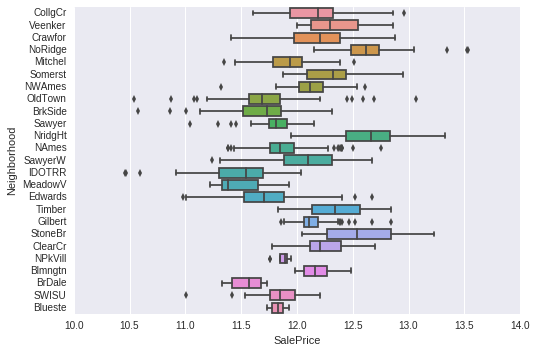

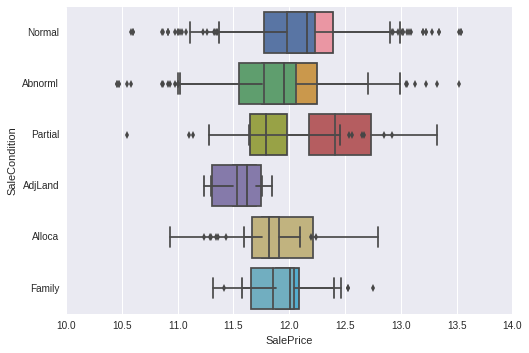

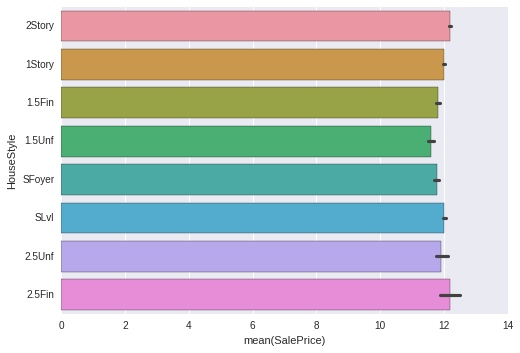

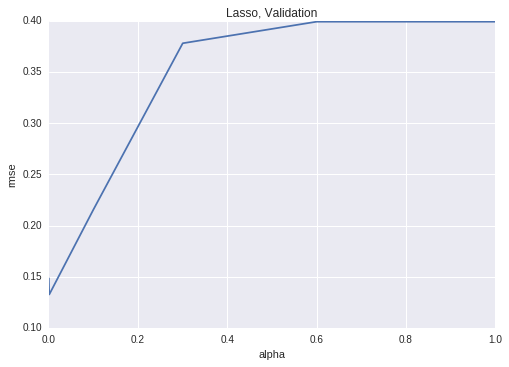

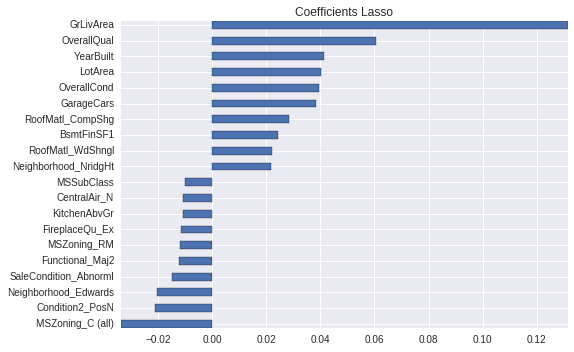


Prediction Stats:
(1095, 270) (365, 270) (1095,) (365,)
(1019, 270) (340, 270) (1019,) (340,)
('best LassoCV alpha:', 0.0030000000000000001)

SCORE Lasso linear model:---------------------------------------------------
0.933224845323
(1019, 270) (340, 270) (1019,) (340,)
('best RidgeCV alpha:', 110)

SCORE Ridge linear model:---------------------------------------------------
0.938982154329
(1359, 79)
(1459, 79)
(1019, 79) (340, 79) (1019,) (340,)

SCORE RidgeCV regressor (feature select):---------------------------------------------------
0.932411108533
(1019, 270) (340, 270) (1019,) (340,)


/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Best score: 0.827986604377
Best parameters: {'n_estimators': 200, 'max_depth': 8}
(1359, 104)
(1459, 104)
(1019, 104) (340, 104) (1019,) (340,)

SCORE Lasso regressor (feature select):---------------------------------------------------
0.933225423715
(1019, 270) (340, 270) (1019,) (340,)


/home/mizio/anaconda2/envs/kaggle_xgboost_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



SCORE XGBRegressor train data:---------------------------------------------------
0.857933930515
{'n_estimators': 240, 'max_depth': 4}


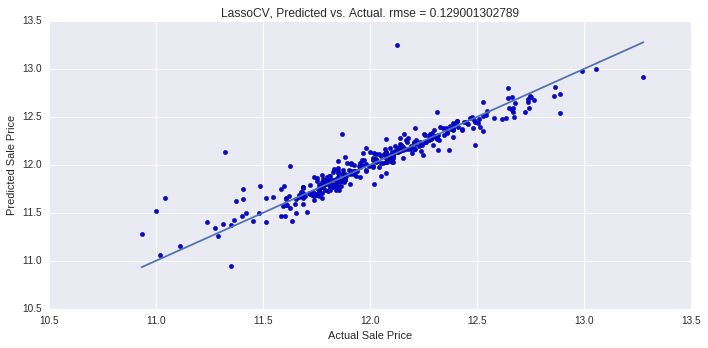

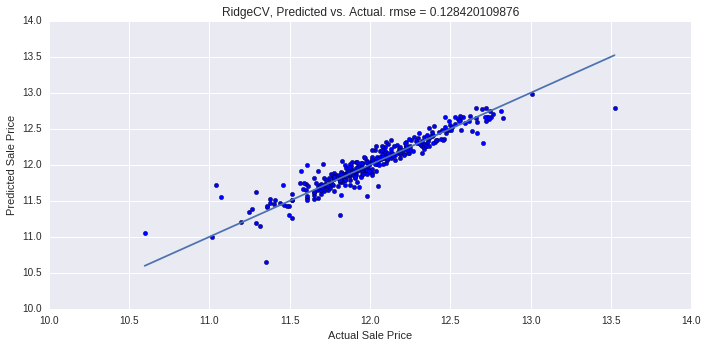

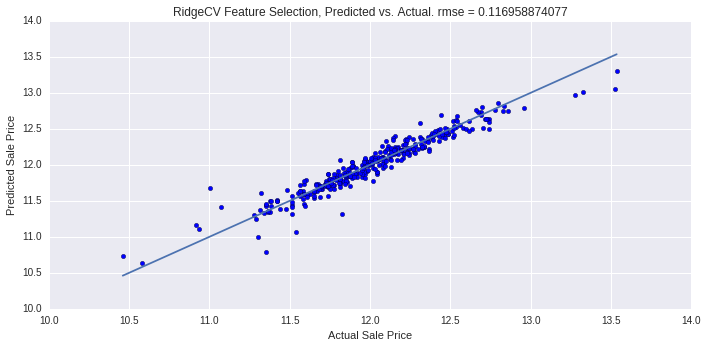

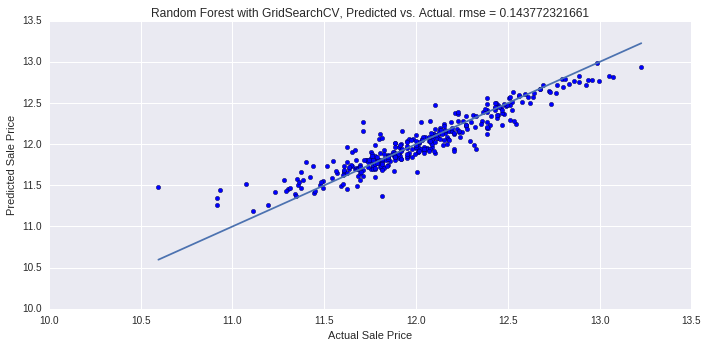

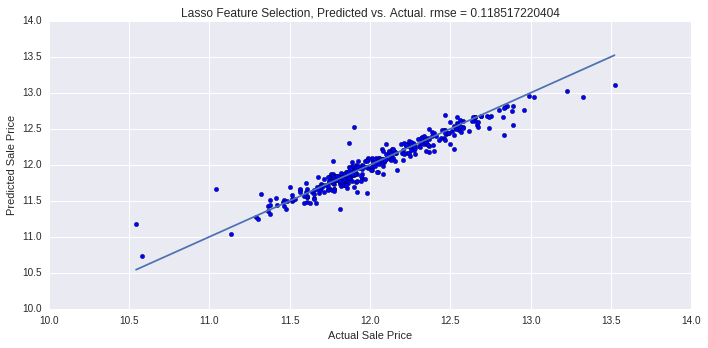

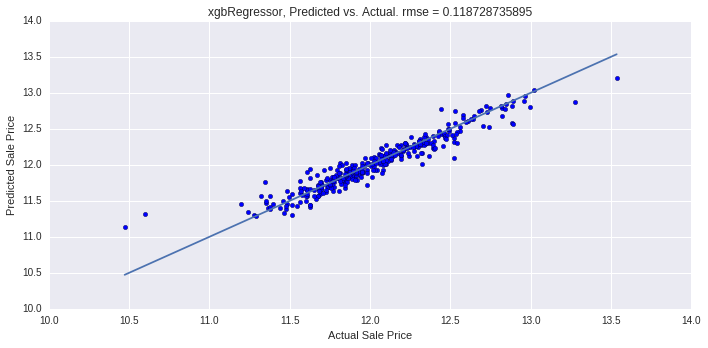

In [4]:
if __name__ == '__main__':
    main()